In [1]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import pickle

from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, LSTM, TimeDistributed, InputLayer, Reshape, BatchNormalization, Bidirectional

2022-12-15 15:42:27.317827: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
metadata = pd.read_csv("/datasets/nicolas_facchinetti/processed_data/emodb/metadata_final.csv")
# metadata = pd.read_csv("D:\\Scuola\\TesiMag\\thesis_adversarial_ml_audio\\processed_data//emodb/metadata_final.csv")
metadata

,path,filename,chunk,label,actor,gender,mod
0,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,0,sad,13,f,0
1,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,1,sad,13,f,0
2,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,0,sad,13,f,1
3,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,1,sad,13,f,1
4,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,0,sad,13,f,1
...,...,...,...,...,...,...,...
4144,/datasets/nicolas_facchinetti/emodb/data/08b01...,08b01Fe.wav,0,happy,8,f,2
4145,/datasets/nicolas_facchinetti/emodb/data/08b01...,08b01Fe.wav,1,happy,8,f,2
4146,/datasets/nicolas_facchinetti/emodb/data/08b01...,08b01Fe.wav,0,happy,8,f,2
4147,/datasets/nicolas_facchinetti/emodb/data/08b01...,08b01Fe.wav,0,happy,8,f,2


0: no normalization technique<br>1: sum of each matrix cell equal 1<br>2: each cell in matrix is divided by the maximum value of the matrix<br>3: MinMax scaler to each sample's matrix

In [6]:
data0 = pickle.load(open("/datasets/nicolas_facchinetti/processed_data/emodb/processed_data0.p", "rb" ))
data1 = pickle.load(open("/datasets/nicolas_facchinetti/processed_data/emodb/processed_data1.p", "rb" ))
data2 = pickle.load(open("/datasets/nicolas_facchinetti/processed_data/emodb/processed_data2.p", "rb" ))
data3 = pickle.load(open("/datasets/nicolas_facchinetti/processed_data/emodb/processed_data3.p", "rb" ))
data0['x'].shape, data0['y'].shape, data1['x'].shape, data1['y'].shape, data2['x'].shape, data2['y'].shape, data3['x'].shape, data3['y'].shape,

((4149, 261, 128, 1),
 (4149, 5),
 (4149, 261, 128, 1),
 (4149, 5),
 (4149, 261, 128, 1),
 (4149, 5),
 (4149, 261, 128, 1),
 (4149, 5))

In [40]:
import matplotlib.pyplot as plt
from collections.abc import Iterable

def plot_res_acc(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_res_loss(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_stats(h):
    fig = plt.gcf()
    fig.set_size_inches(15, 15)
    for num, c in enumerate(h):
        n = (num+1)*2
        plot_res_acc(c, len(h), n-1)
        plot_res_loss(c, len(h), n)
    plt.show()

In [42]:
def train_evaluate(model_fn, train, val, opt='adam'):
    m = model_fn()
    m.compile(loss='categorical_crossentropy', optimizer=opt, metrics='accuracy')
    # fit & predict
    history = m.fit(train[0], train[1],
                    epochs=50,
                    batch_size=32,
                    validation_data=(val[0], val[1]),
                    verbose=1)
    print("Done")
    return history

In [35]:
from sklearn.model_selection import train_test_split

def train_kfold(model_fn, x, y, metadata, n=[1997,1941,1965]):    
    results = []
    
    for rs in n:
        train_df, test_df = train_test_split(metadata, 
                                   test_size = 0.15, 
                                   random_state = rs,
                                   stratify = metadata['label'])
        train_index = train_df.index
        test_index = test_df.index
        x_train = x[train_index]
        y_train = y[train_index]
        x_test = x[test_index]
        y_test = y[test_index]
        
        results.append(train_evaluate(model_fn, (x_train, y_train), (x_test, y_test)))
    return results

# Model definition

In [13]:
def get_m():
    m = Sequential([
            InputLayer(input_shape=(261,128,1)),
            Reshape((9,29,128,1)),
            TimeDistributed(Conv2D(16, kernel_size=(5,5), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(4,4), strides=2)),

            TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),
            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),
            
            LSTM(3, return_sequences=False, dropout=0.2),
            Dense(5, activation='softmax')
    ])
    return m

get_m().summary()

2022-12-15 15:52:32.053868: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-15 15:52:32.055120: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-15 15:52:32.162068: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:15:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 607.97GiB/s
2022-12-15 15:52:32.162109: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-15 15:52:32.178215: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-15 15:52:32.178316: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 9, 29, 128, 1)     0         
_________________________________________________________________
time_distributed (TimeDistri (None, 9, 25, 124, 16)    416       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 9, 25, 124, 16)    64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 9, 11, 61, 16)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 9, 9, 59, 32)      4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 9, 4, 29, 32)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 9, 2, 27, 64)      1

# Without standardization

In [43]:
l0 = train_kfold(get_m, data0['x'], data0['y'], metadata)

Epoch 1/50
111/111 [==============================] - 3s 21ms/step - loss: 1.5910 - accuracy: 0.2213 - val_loss: 1.5879 - val_accuracy: 0.3435
Epoch 2/50
111/111 [==============================] - 2s 14ms/step - loss: 1.4903 - accuracy: 0.3778 - val_loss: 1.4495 - val_accuracy: 0.4013
Epoch 3/50
111/111 [==============================] - 2s 15ms/step - loss: 1.4485 - accuracy: 0.4035 - val_loss: 1.4062 - val_accuracy: 0.4061
Epoch 4/50
111/111 [==============================] - 2s 15ms/step - loss: 1.3705 - accuracy: 0.4151 - val_loss: 1.3346 - val_accuracy: 0.3724
Epoch 5/50
111/111 [==============================] - 2s 15ms/step - loss: 1.2200 - accuracy: 0.5059 - val_loss: 1.1305 - val_accuracy: 0.5746
Epoch 6/50
111/111 [==============================] - 2s 15ms/step - loss: 1.1544 - accuracy: 0.5353 - val_loss: 1.3940 - val_accuracy: 0.4719
Epoch 7/50
111/111 [==============================] - 2s 15ms/step - loss: 1.1387 - accuracy: 0.5522 - val_loss: 1.1158 - val_accuracy: 0.5313

Epoch 8/50
111/111 [==============================] - 2s 15ms/step - loss: 1.0841 - accuracy: 0.6365 - val_loss: 1.1351 - val_accuracy: 0.5730
Epoch 9/50
111/111 [==============================] - 2s 14ms/step - loss: 1.0336 - accuracy: 0.6536 - val_loss: 1.0531 - val_accuracy: 0.6244
Epoch 10/50
111/111 [==============================] - 2s 15ms/step - loss: 1.0139 - accuracy: 0.6471 - val_loss: 1.0125 - val_accuracy: 0.6453
Epoch 11/50
111/111 [==============================] - 2s 15ms/step - loss: 0.9861 - accuracy: 0.6604 - val_loss: 0.9993 - val_accuracy: 0.6485
Epoch 12/50
111/111 [==============================] - 2s 15ms/step - loss: 0.9459 - accuracy: 0.6646 - val_loss: 0.9701 - val_accuracy: 0.6485
Epoch 13/50
111/111 [==============================] - 2s 15ms/step - loss: 0.9117 - accuracy: 0.6693 - val_loss: 0.9515 - val_accuracy: 0.6517
Epoch 14/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8916 - accuracy: 0.6757 - val_loss: 1.0033 - val_accuracy: 0

Epoch 15/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8121 - accuracy: 0.7124 - val_loss: 1.1654 - val_accuracy: 0.5152
Epoch 16/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8346 - accuracy: 0.6951 - val_loss: 0.9253 - val_accuracy: 0.6437
Epoch 17/50
111/111 [==============================] - 2s 15ms/step - loss: 0.7964 - accuracy: 0.6980 - val_loss: 0.8369 - val_accuracy: 0.6758
Epoch 18/50
111/111 [==============================] - 2s 15ms/step - loss: 0.7681 - accuracy: 0.7283 - val_loss: 0.9532 - val_accuracy: 0.6019
Epoch 19/50
111/111 [==============================] - 2s 15ms/step - loss: 0.7407 - accuracy: 0.7355 - val_loss: 0.7866 - val_accuracy: 0.7047
Epoch 20/50
111/111 [==============================] - 2s 15ms/step - loss: 0.7287 - accuracy: 0.7261 - val_loss: 0.9943 - val_accuracy: 0.5923
Epoch 21/50
111/111 [==============================] - 2s 15ms/step - loss: 0.7220 - accuracy: 0.7333 - val_loss: 0.7973 - val_accuracy:

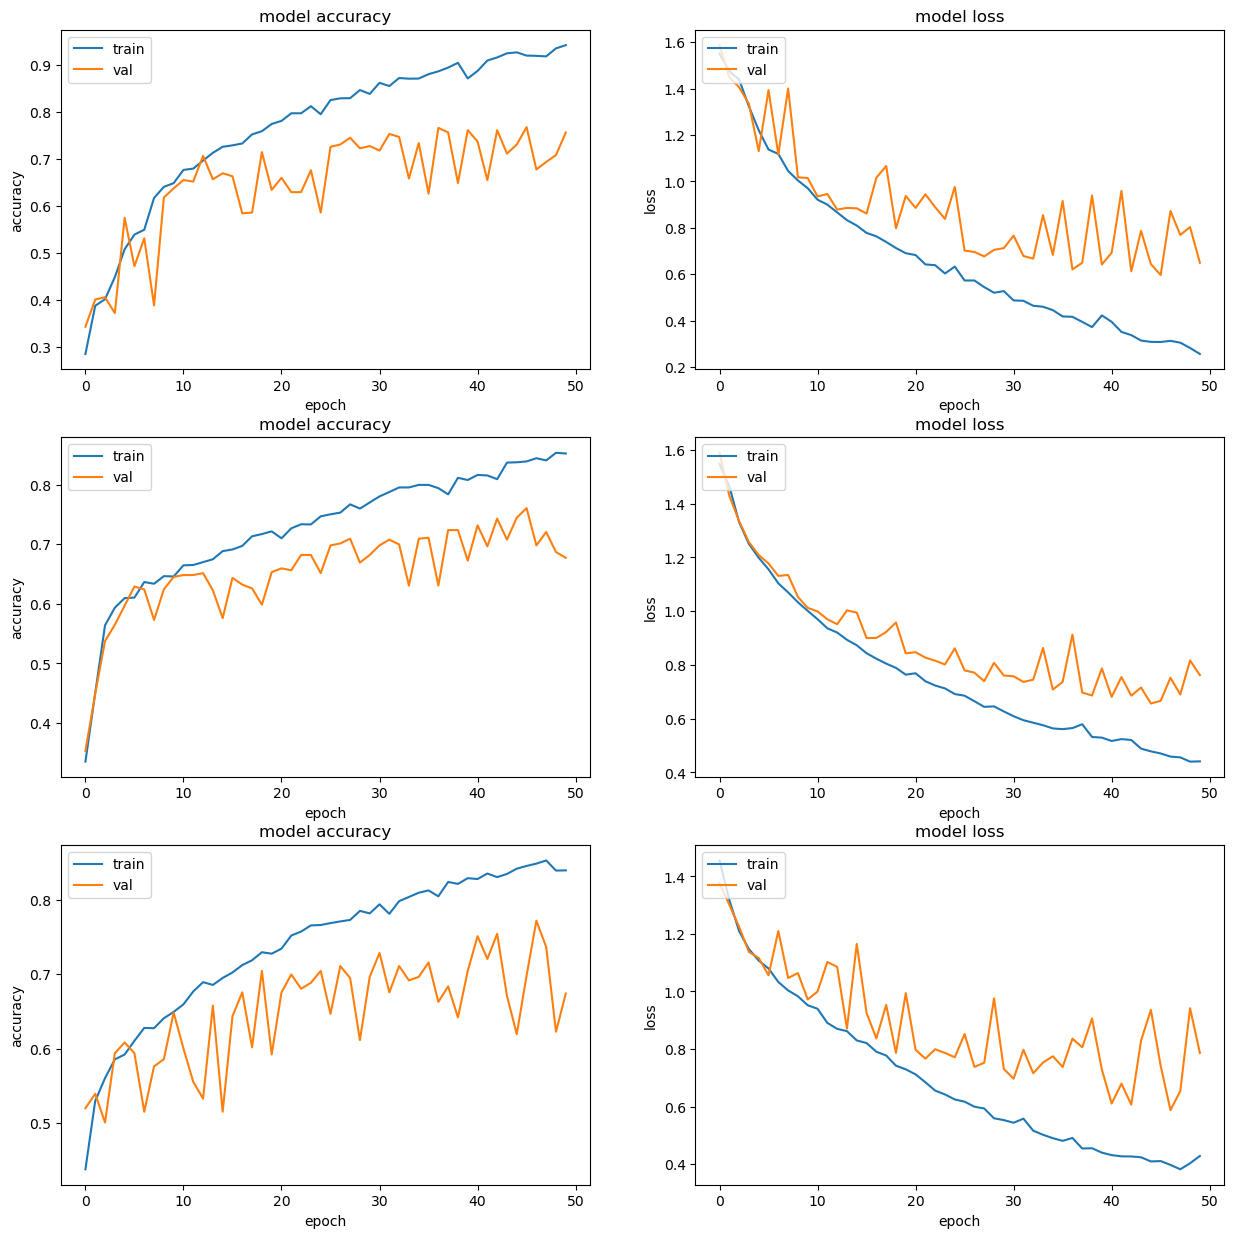

In [44]:
plot_stats(l0)

In [45]:
l1 = train_kfold(get_m, data1['x'], data1['y'], metadata)


Epoch 1/50
111/111 [==============================] - 3s 18ms/step - loss: 1.6067 - accuracy: 0.2044 - val_loss: 1.6044 - val_accuracy: 0.2472
Epoch 2/50
111/111 [==============================] - 2s 15ms/step - loss: 1.6043 - accuracy: 0.2393 - val_loss: 1.6012 - val_accuracy: 0.2472
Epoch 3/50
111/111 [==============================] - 2s 15ms/step - loss: 1.6031 - accuracy: 0.2348 - val_loss: 1.6000 - val_accuracy: 0.2472
Epoch 4/50
111/111 [==============================] - 2s 15ms/step - loss: 1.6017 - accuracy: 0.2446 - val_loss: 1.5996 - val_accuracy: 0.2472
Epoch 5/50
111/111 [==============================] - 2s 15ms/step - loss: 1.6015 - accuracy: 0.2408 - val_loss: 1.5995 - val_accuracy: 0.2472
Epoch 6/50
111/111 [==============================] - 2s 14ms/step - loss: 1.5890 - accuracy: 0.2608 - val_loss: 1.7884 - val_accuracy: 0.2119
Epoch 7/50
111/111 [==============================] - 2s 15ms/step - loss: 1.3179 - accuracy: 0.4701 - val_loss: 1.9810 - val_accuracy: 0.2119

Epoch 8/50
111/111 [==============================] - 2s 14ms/step - loss: 1.5947 - accuracy: 0.2673 - val_loss: 1.6004 - val_accuracy: 0.2472
Epoch 9/50
111/111 [==============================] - 2s 15ms/step - loss: 1.6027 - accuracy: 0.2368 - val_loss: 1.5995 - val_accuracy: 0.2472
Epoch 10/50
111/111 [==============================] - 2s 15ms/step - loss: 1.6023 - accuracy: 0.2368 - val_loss: 1.5994 - val_accuracy: 0.2472
Epoch 11/50
111/111 [==============================] - 2s 15ms/step - loss: 1.5952 - accuracy: 0.2546 - val_loss: 1.5995 - val_accuracy: 0.2472
Epoch 12/50
111/111 [==============================] - 2s 14ms/step - loss: 1.5978 - accuracy: 0.2632 - val_loss: 1.5989 - val_accuracy: 0.4061
Epoch 13/50
111/111 [==============================] - 2s 15ms/step - loss: 1.5322 - accuracy: 0.3371 - val_loss: 2.0384 - val_accuracy: 0.2119
Epoch 14/50
111/111 [==============================] - 2s 15ms/step - loss: 1.2637 - accuracy: 0.4677 - val_loss: 2.2345 - val_accuracy: 0

Epoch 15/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8673 - accuracy: 0.6548 - val_loss: 2.3150 - val_accuracy: 0.2488
Epoch 16/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8617 - accuracy: 0.6459 - val_loss: 2.5166 - val_accuracy: 0.2488
Epoch 17/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8308 - accuracy: 0.6613 - val_loss: 2.7422 - val_accuracy: 0.2472
Epoch 18/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8244 - accuracy: 0.6666 - val_loss: 2.7911 - val_accuracy: 0.2472
Epoch 19/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8154 - accuracy: 0.6701 - val_loss: 2.8465 - val_accuracy: 0.2472
Epoch 20/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8205 - accuracy: 0.6675 - val_loss: 2.8943 - val_accuracy: 0.2472
Epoch 21/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8152 - accuracy: 0.6612 - val_loss: 2.9355 - val_accuracy:

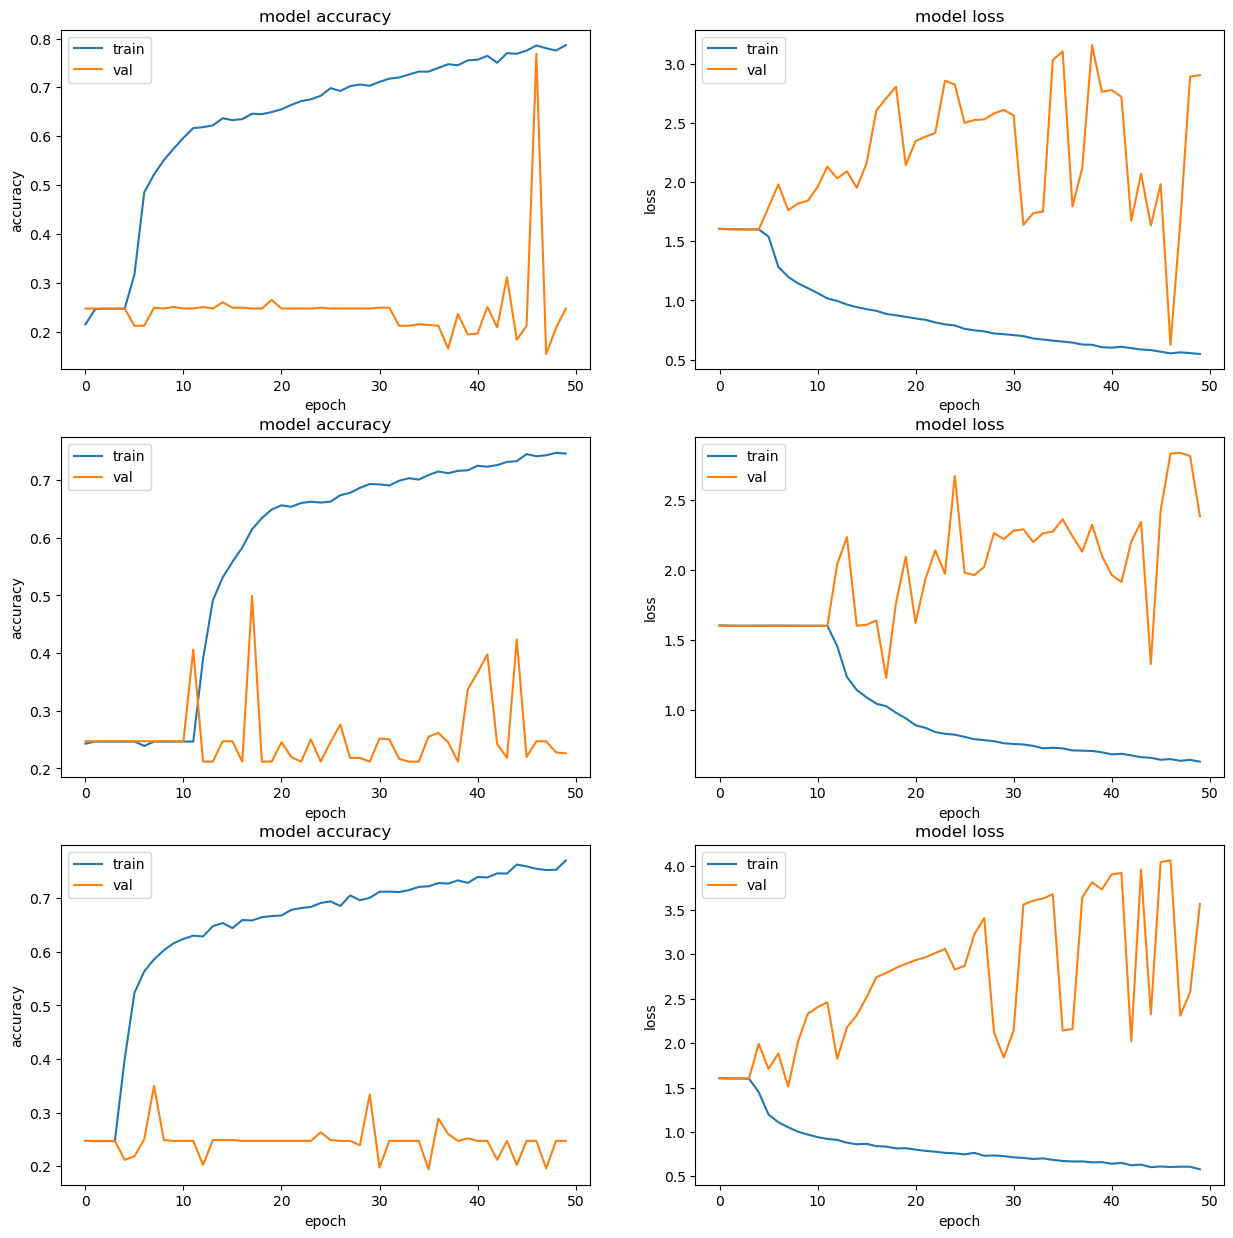

In [46]:
plot_stats(l1)

In [47]:
l2 = train_kfold(get_m, data2['x'], data2['y'], metadata)

Epoch 1/50
111/111 [==============================] - 3s 18ms/step - loss: 1.5622 - accuracy: 0.2890 - val_loss: 1.5753 - val_accuracy: 0.3018
Epoch 2/50
111/111 [==============================] - 2s 15ms/step - loss: 1.4168 - accuracy: 0.4778 - val_loss: 1.4582 - val_accuracy: 0.4446
Epoch 3/50
111/111 [==============================] - 2s 15ms/step - loss: 1.3204 - accuracy: 0.4951 - val_loss: 1.3895 - val_accuracy: 0.4366
Epoch 4/50
111/111 [==============================] - 2s 15ms/step - loss: 1.2378 - accuracy: 0.5340 - val_loss: 1.2422 - val_accuracy: 0.4719
Epoch 5/50
111/111 [==============================] - 2s 15ms/step - loss: 1.2045 - accuracy: 0.5298 - val_loss: 1.2136 - val_accuracy: 0.5939
Epoch 6/50
111/111 [==============================] - 2s 15ms/step - loss: 1.1737 - accuracy: 0.5558 - val_loss: 1.1621 - val_accuracy: 0.5249
Epoch 7/50
111/111 [==============================] - 2s 15ms/step - loss: 1.1244 - accuracy: 0.5759 - val_loss: 1.1300 - val_accuracy: 0.5120

Epoch 8/50
111/111 [==============================] - 2s 15ms/step - loss: 0.7860 - accuracy: 0.7120 - val_loss: 0.8177 - val_accuracy: 0.6726
Epoch 9/50
111/111 [==============================] - 2s 15ms/step - loss: 0.7661 - accuracy: 0.7143 - val_loss: 0.8609 - val_accuracy: 0.6709
Epoch 10/50
111/111 [==============================] - 2s 15ms/step - loss: 0.7362 - accuracy: 0.7288 - val_loss: 0.7831 - val_accuracy: 0.7095
Epoch 11/50
111/111 [==============================] - 2s 15ms/step - loss: 0.7121 - accuracy: 0.7361 - val_loss: 0.7979 - val_accuracy: 0.7014
Epoch 12/50
111/111 [==============================] - 2s 15ms/step - loss: 0.6848 - accuracy: 0.7464 - val_loss: 0.8187 - val_accuracy: 0.6661
Epoch 13/50
111/111 [==============================] - 2s 15ms/step - loss: 0.6571 - accuracy: 0.7647 - val_loss: 0.9344 - val_accuracy: 0.6228
Epoch 14/50
111/111 [==============================] - 2s 15ms/step - loss: 0.6249 - accuracy: 0.7717 - val_loss: 1.3709 - val_accuracy: 0

Epoch 15/50
111/111 [==============================] - 1s 13ms/step - loss: 0.6430 - accuracy: 0.7761 - val_loss: 0.7238 - val_accuracy: 0.7287
Epoch 16/50
111/111 [==============================] - 1s 13ms/step - loss: 0.6280 - accuracy: 0.7883 - val_loss: 0.8911 - val_accuracy: 0.6709
Epoch 17/50
111/111 [==============================] - 1s 13ms/step - loss: 0.6140 - accuracy: 0.7886 - val_loss: 1.0961 - val_accuracy: 0.5634
Epoch 18/50
111/111 [==============================] - 1s 13ms/step - loss: 0.5818 - accuracy: 0.8056 - val_loss: 0.6929 - val_accuracy: 0.7416
Epoch 19/50
111/111 [==============================] - 2s 15ms/step - loss: 0.5340 - accuracy: 0.8192 - val_loss: 0.6651 - val_accuracy: 0.7560
Epoch 20/50
111/111 [==============================] - 2s 15ms/step - loss: 0.4913 - accuracy: 0.8487 - val_loss: 0.6984 - val_accuracy: 0.7464
Epoch 21/50
111/111 [==============================] - 2s 15ms/step - loss: 0.4892 - accuracy: 0.8455 - val_loss: 0.5816 - val_accuracy:

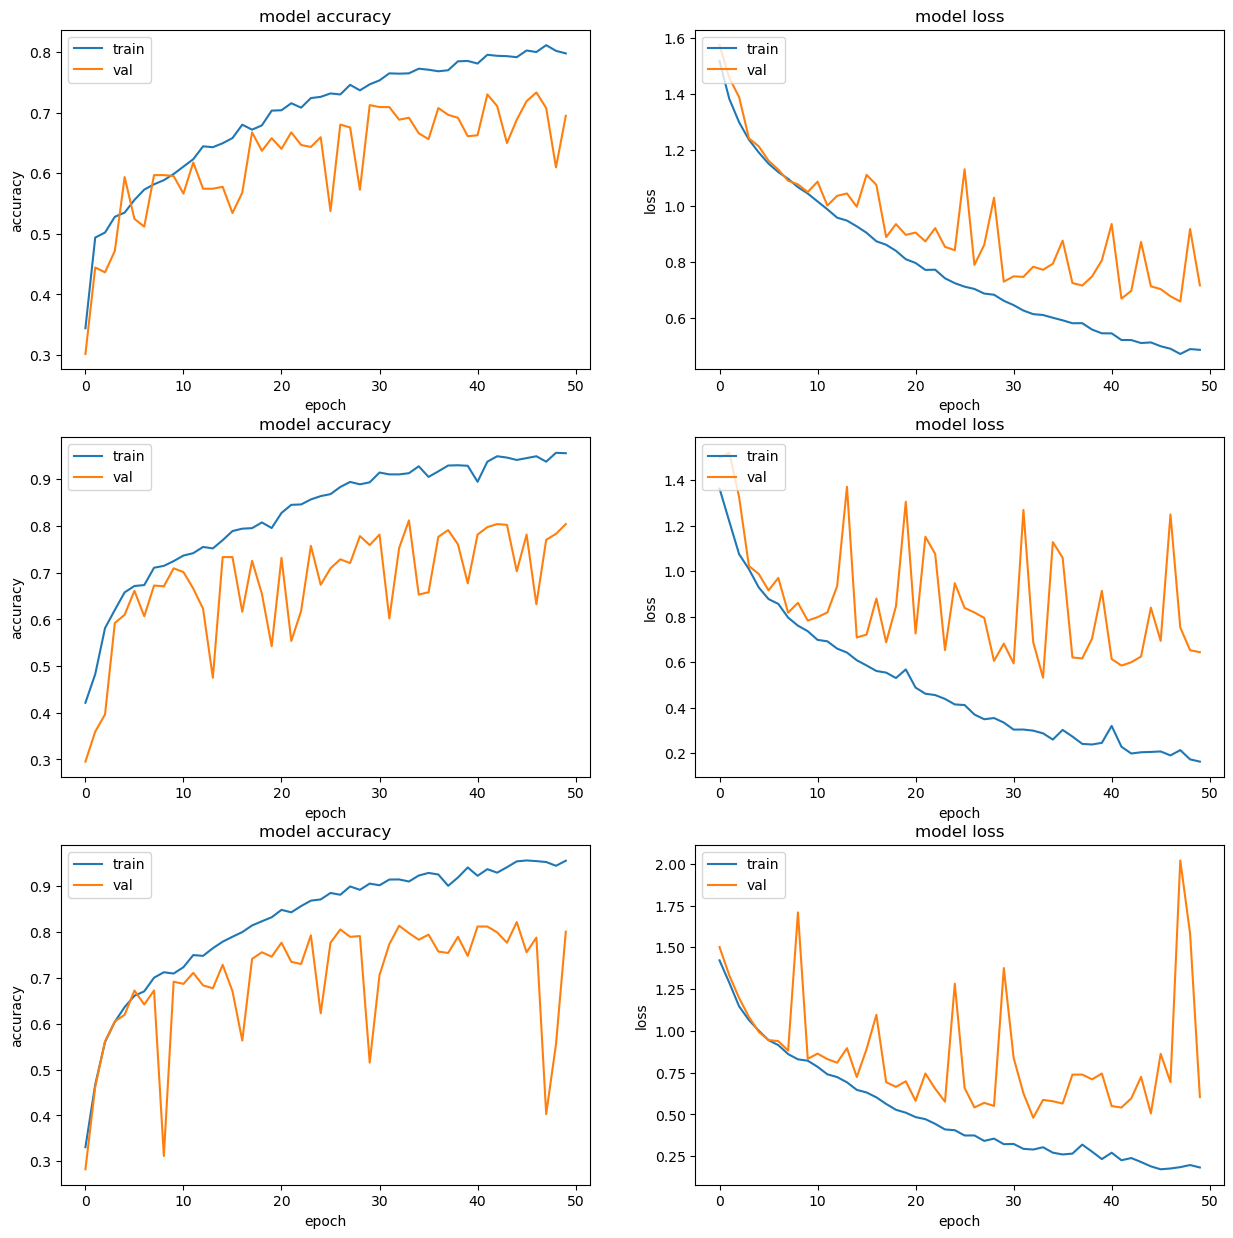

In [48]:
plot_stats(l2)

In [49]:
l3 = train_kfold(get_m, data3['x'], data3['y'], metadata)

Epoch 1/50
111/111 [==============================] - 3s 17ms/step - loss: 1.6065 - accuracy: 0.1889 - val_loss: 1.5889 - val_accuracy: 0.2472
Epoch 2/50
111/111 [==============================] - 2s 15ms/step - loss: 1.5077 - accuracy: 0.2903 - val_loss: 1.5860 - val_accuracy: 0.2472
Epoch 3/50
111/111 [==============================] - 2s 15ms/step - loss: 1.4161 - accuracy: 0.3765 - val_loss: 1.5028 - val_accuracy: 0.2937
Epoch 4/50
111/111 [==============================] - 2s 15ms/step - loss: 1.3736 - accuracy: 0.4521 - val_loss: 1.4722 - val_accuracy: 0.3130
Epoch 5/50
111/111 [==============================] - 2s 14ms/step - loss: 1.3046 - accuracy: 0.4940 - val_loss: 1.2978 - val_accuracy: 0.4671
Epoch 6/50
111/111 [==============================] - 1s 13ms/step - loss: 1.2708 - accuracy: 0.5139 - val_loss: 1.2520 - val_accuracy: 0.4992
Epoch 7/50
111/111 [==============================] - 1s 13ms/step - loss: 1.2222 - accuracy: 0.5404 - val_loss: 1.2196 - val_accuracy: 0.5570

Epoch 8/50
111/111 [==============================] - 2s 15ms/step - loss: 0.9465 - accuracy: 0.6715 - val_loss: 0.9630 - val_accuracy: 0.6404
Epoch 9/50
111/111 [==============================] - 2s 14ms/step - loss: 0.9005 - accuracy: 0.6929 - val_loss: 0.9920 - val_accuracy: 0.6067
Epoch 10/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8507 - accuracy: 0.7172 - val_loss: 0.9563 - val_accuracy: 0.6212
Epoch 11/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8269 - accuracy: 0.7265 - val_loss: 0.9243 - val_accuracy: 0.6372
Epoch 12/50
111/111 [==============================] - 2s 15ms/step - loss: 0.7839 - accuracy: 0.7496 - val_loss: 0.8957 - val_accuracy: 0.6388
Epoch 13/50
111/111 [==============================] - 2s 15ms/step - loss: 0.7571 - accuracy: 0.7650 - val_loss: 0.8879 - val_accuracy: 0.6693
Epoch 14/50
111/111 [==============================] - 2s 15ms/step - loss: 0.7290 - accuracy: 0.7715 - val_loss: 0.8659 - val_accuracy: 0

Epoch 15/50
111/111 [==============================] - 1s 13ms/step - loss: 0.8358 - accuracy: 0.7041 - val_loss: 0.8957 - val_accuracy: 0.6485
Epoch 16/50
111/111 [==============================] - 1s 13ms/step - loss: 0.8170 - accuracy: 0.7092 - val_loss: 0.8844 - val_accuracy: 0.6533
Epoch 17/50
111/111 [==============================] - 1s 13ms/step - loss: 0.8117 - accuracy: 0.7073 - val_loss: 0.8500 - val_accuracy: 0.6693
Epoch 18/50
111/111 [==============================] - 1s 13ms/step - loss: 0.7849 - accuracy: 0.7125 - val_loss: 0.8431 - val_accuracy: 0.6709
Epoch 19/50
111/111 [==============================] - 1s 13ms/step - loss: 0.7609 - accuracy: 0.7303 - val_loss: 0.8214 - val_accuracy: 0.6709
Epoch 20/50
111/111 [==============================] - 1s 13ms/step - loss: 0.7150 - accuracy: 0.7407 - val_loss: 0.8144 - val_accuracy: 0.6790
Epoch 21/50
111/111 [==============================] - 1s 13ms/step - loss: 0.7349 - accuracy: 0.7184 - val_loss: 0.8024 - val_accuracy:

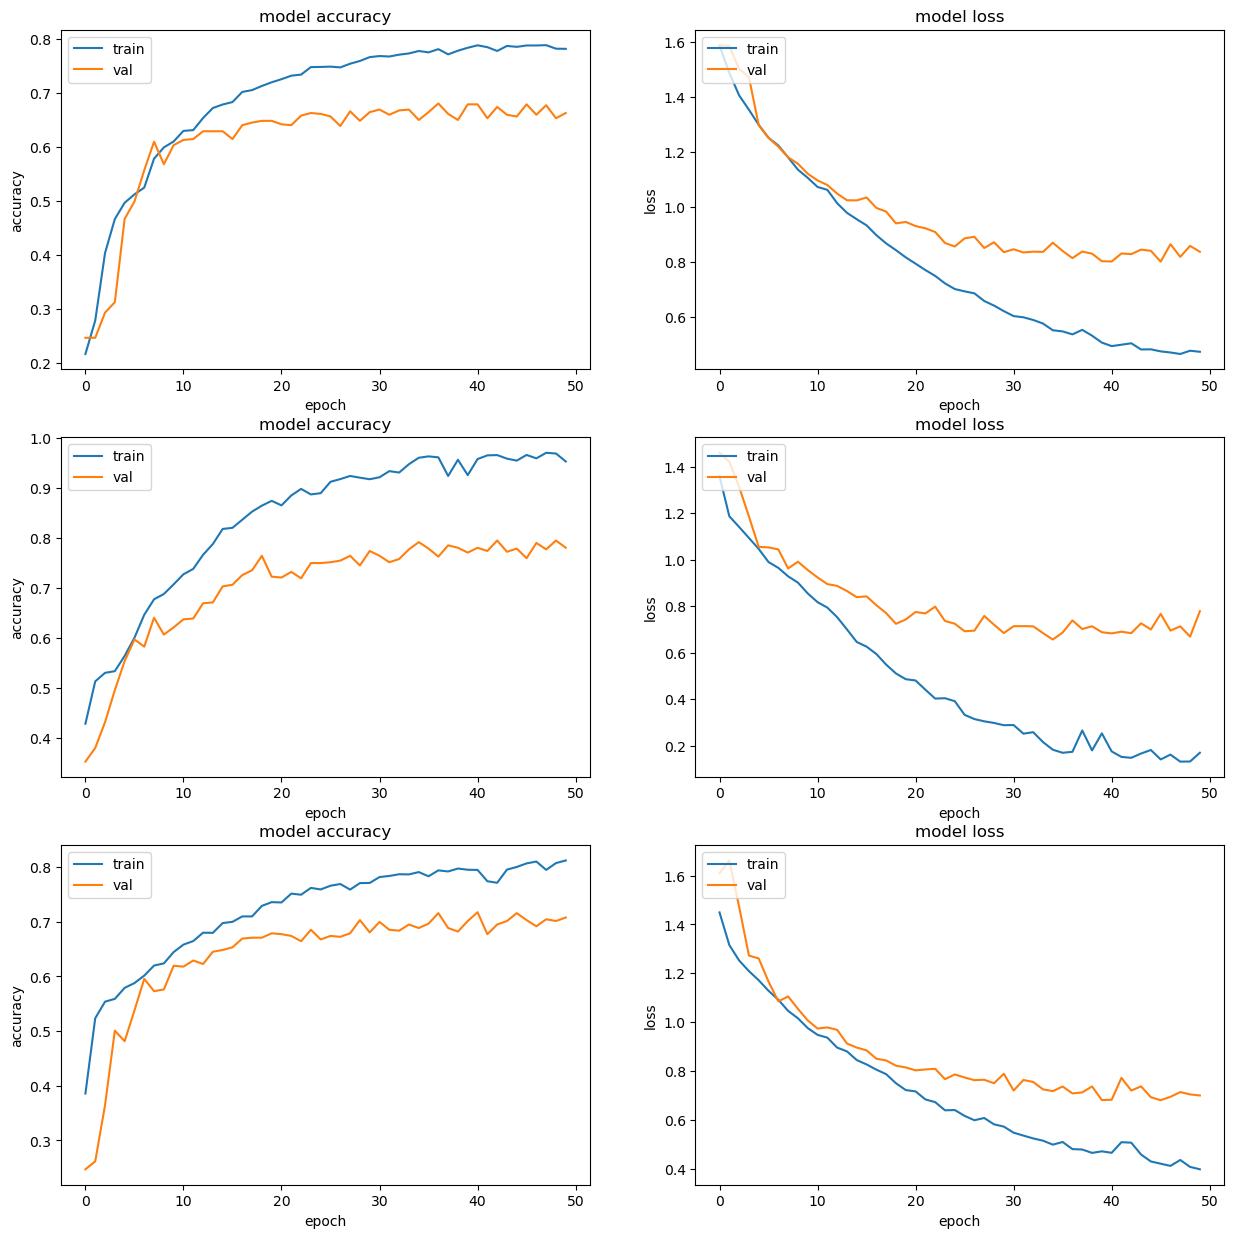

In [50]:
plot_stats(l3)

# With standardization

Standardize samples' matrix<br>The matrix are flatted to an array of features and the resulting dataset is transformed to have mean 0 and std 1

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [54]:
data0['x'].flatten().shape

(138609792,)

In [55]:
data0['xs'] = scaler.fit_transform(data0['x'].reshape(4149,-1)).reshape((4149, 261, 128, 1))
data1['xs'] = scaler.fit_transform(data1['x'].reshape(4149,-1)).reshape((4149, 261, 128, 1))
data2['xs'] = scaler.fit_transform(data2['x'].reshape(4149,-1)).reshape((4149, 261, 128, 1))
data3['xs'] = scaler.fit_transform(data3['x'].reshape(4149,-1)).reshape((4149, 261, 128, 1))

In [61]:
data0['xs'].std(), data0['xs'].mean()

(1.000001, 4.179336e-08)

In [62]:
l0 = train_kfold(get_m, data0['xs'], data0['y'], metadata)

Epoch 1/50
111/111 [==============================] - 4s 18ms/step - loss: 1.4441 - accuracy: 0.3753 - val_loss: 1.2935 - val_accuracy: 0.4478
Epoch 2/50
111/111 [==============================] - 2s 14ms/step - loss: 1.2350 - accuracy: 0.4561 - val_loss: 1.1958 - val_accuracy: 0.4623
Epoch 3/50
111/111 [==============================] - 2s 14ms/step - loss: 1.1545 - accuracy: 0.4827 - val_loss: 1.1029 - val_accuracy: 0.5008
Epoch 4/50
111/111 [==============================] - 2s 14ms/step - loss: 1.0802 - accuracy: 0.5282 - val_loss: 1.0529 - val_accuracy: 0.5586
Epoch 5/50
111/111 [==============================] - 2s 14ms/step - loss: 1.0326 - accuracy: 0.5721 - val_loss: 1.0102 - val_accuracy: 0.5843
Epoch 6/50
111/111 [==============================] - 2s 15ms/step - loss: 0.9937 - accuracy: 0.6154 - val_loss: 0.9848 - val_accuracy: 0.6629
Epoch 7/50
111/111 [==============================] - 2s 14ms/step - loss: 0.9217 - accuracy: 0.6879 - val_loss: 0.9288 - val_accuracy: 0.6517

Epoch 8/50
111/111 [==============================] - 2s 14ms/step - loss: 0.9406 - accuracy: 0.6572 - val_loss: 0.9546 - val_accuracy: 0.6533
Epoch 9/50
111/111 [==============================] - 2s 14ms/step - loss: 0.9368 - accuracy: 0.6635 - val_loss: 0.9361 - val_accuracy: 0.6517
Epoch 10/50
111/111 [==============================] - 2s 14ms/step - loss: 0.9113 - accuracy: 0.6652 - val_loss: 0.9157 - val_accuracy: 0.6565
Epoch 11/50
111/111 [==============================] - 2s 15ms/step - loss: 0.9223 - accuracy: 0.6481 - val_loss: 0.8972 - val_accuracy: 0.6501
Epoch 12/50
111/111 [==============================] - 2s 14ms/step - loss: 0.8515 - accuracy: 0.6785 - val_loss: 0.8840 - val_accuracy: 0.6645
Epoch 13/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8506 - accuracy: 0.6725 - val_loss: 0.8809 - val_accuracy: 0.6565
Epoch 14/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8652 - accuracy: 0.6722 - val_loss: 0.8502 - val_accuracy: 0

Epoch 15/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8736 - accuracy: 0.6756 - val_loss: 0.8672 - val_accuracy: 0.6613
Epoch 16/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8936 - accuracy: 0.6542 - val_loss: 0.8933 - val_accuracy: 0.6453
Epoch 17/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8539 - accuracy: 0.6736 - val_loss: 0.8415 - val_accuracy: 0.6693
Epoch 18/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8400 - accuracy: 0.6794 - val_loss: 0.8290 - val_accuracy: 0.6822
Epoch 19/50
111/111 [==============================] - 2s 14ms/step - loss: 0.8207 - accuracy: 0.6772 - val_loss: 0.8545 - val_accuracy: 0.6453
Epoch 20/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8225 - accuracy: 0.6692 - val_loss: 0.7981 - val_accuracy: 0.6870
Epoch 21/50
111/111 [==============================] - 2s 15ms/step - loss: 0.7948 - accuracy: 0.6824 - val_loss: 0.8269 - val_accuracy:

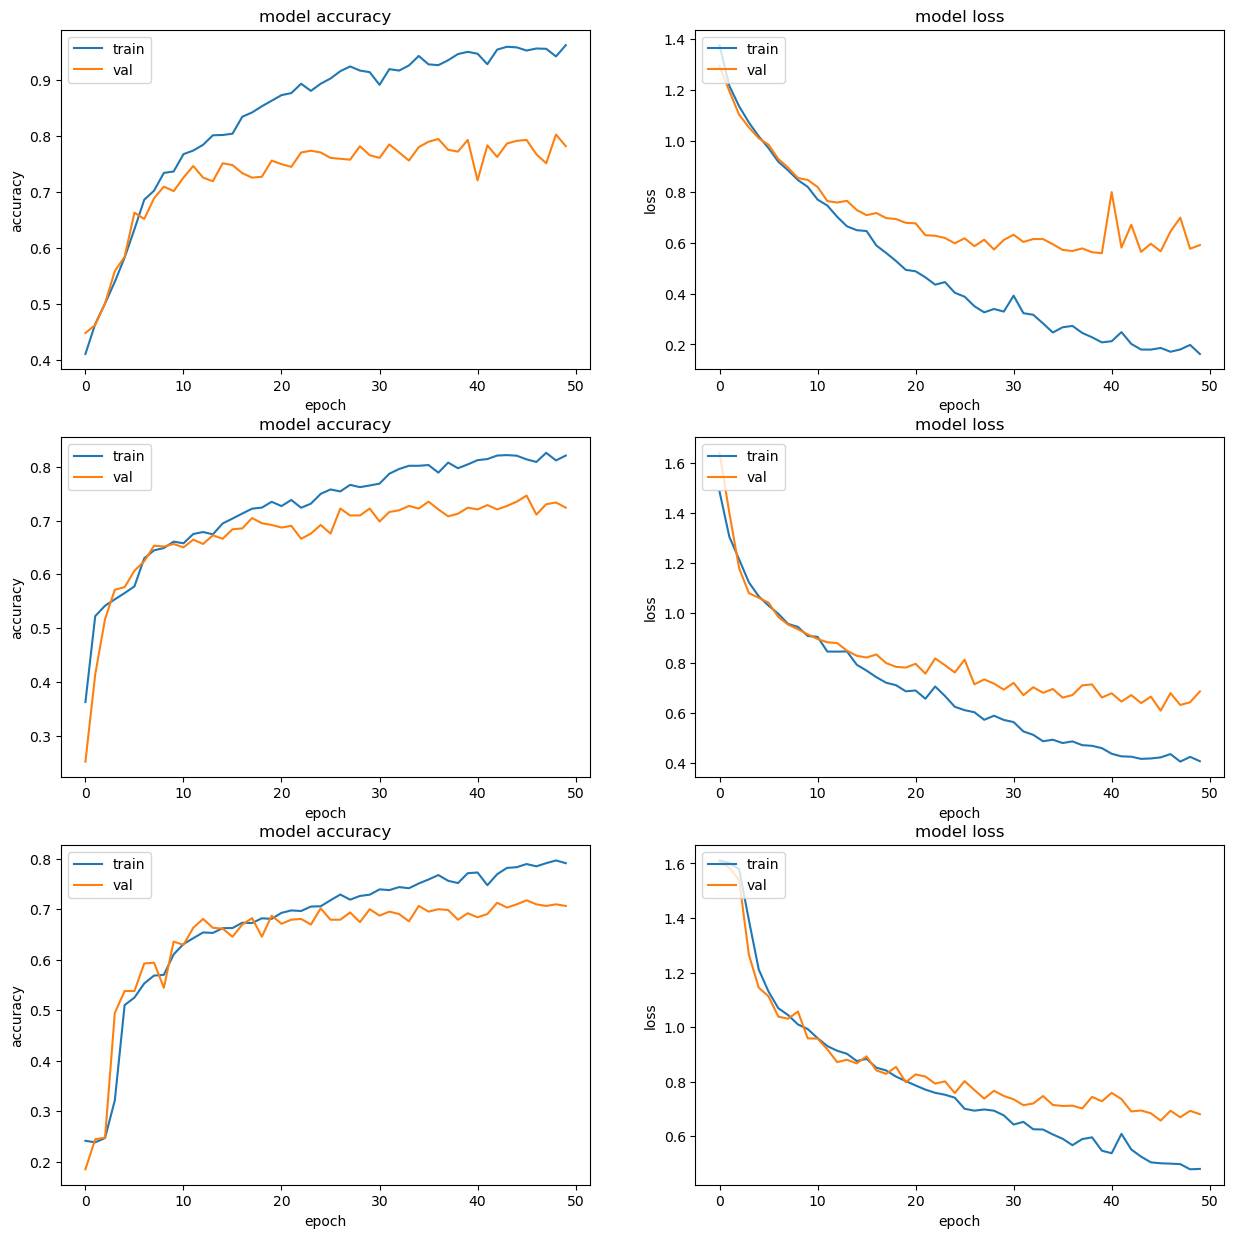

In [63]:
plot_stats(l0)

In [64]:
l1 = train_kfold(get_m, data1['xs'], data1['y'], metadata)


Epoch 1/50
111/111 [==============================] - 3s 18ms/step - loss: 1.5259 - accuracy: 0.3104 - val_loss: 1.4167 - val_accuracy: 0.4591
Epoch 2/50
111/111 [==============================] - 2s 15ms/step - loss: 1.3813 - accuracy: 0.4987 - val_loss: 1.2880 - val_accuracy: 0.5554
Epoch 3/50
111/111 [==============================] - 2s 15ms/step - loss: 1.2733 - accuracy: 0.5549 - val_loss: 1.2073 - val_accuracy: 0.5538
Epoch 4/50
111/111 [==============================] - 2s 15ms/step - loss: 1.2090 - accuracy: 0.5600 - val_loss: 1.1601 - val_accuracy: 0.5586
Epoch 5/50
111/111 [==============================] - 2s 15ms/step - loss: 1.1870 - accuracy: 0.5527 - val_loss: 1.1120 - val_accuracy: 0.5714
Epoch 6/50
111/111 [==============================] - 2s 15ms/step - loss: 1.1195 - accuracy: 0.5571 - val_loss: 1.0966 - val_accuracy: 0.5714
Epoch 7/50
111/111 [==============================] - 2s 15ms/step - loss: 1.0818 - accuracy: 0.5754 - val_loss: 1.0777 - val_accuracy: 0.5730

Epoch 8/50
111/111 [==============================] - 2s 15ms/step - loss: 0.9051 - accuracy: 0.6403 - val_loss: 0.9517 - val_accuracy: 0.6453
Epoch 9/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8492 - accuracy: 0.6612 - val_loss: 0.9289 - val_accuracy: 0.6356
Epoch 10/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8515 - accuracy: 0.6538 - val_loss: 0.9096 - val_accuracy: 0.6469
Epoch 11/50
111/111 [==============================] - 2s 15ms/step - loss: 0.7847 - accuracy: 0.6966 - val_loss: 0.8810 - val_accuracy: 0.6806
Epoch 12/50
111/111 [==============================] - 2s 15ms/step - loss: 0.7994 - accuracy: 0.6896 - val_loss: 0.8700 - val_accuracy: 0.6517
Epoch 13/50
111/111 [==============================] - 2s 15ms/step - loss: 0.7677 - accuracy: 0.7041 - val_loss: 0.9109 - val_accuracy: 0.6388
Epoch 14/50
111/111 [==============================] - 2s 14ms/step - loss: 0.7490 - accuracy: 0.6968 - val_loss: 0.8322 - val_accuracy: 0

Epoch 15/50
111/111 [==============================] - 2s 15ms/step - loss: 0.9578 - accuracy: 0.6162 - val_loss: 0.9696 - val_accuracy: 0.5923
Epoch 16/50
111/111 [==============================] - 2s 15ms/step - loss: 0.9384 - accuracy: 0.5949 - val_loss: 0.9552 - val_accuracy: 0.5698
Epoch 17/50
111/111 [==============================] - 2s 15ms/step - loss: 0.9396 - accuracy: 0.5951 - val_loss: 0.8951 - val_accuracy: 0.5939
Epoch 18/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8826 - accuracy: 0.5929 - val_loss: 1.0079 - val_accuracy: 0.5602
Epoch 19/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8553 - accuracy: 0.6291 - val_loss: 0.8711 - val_accuracy: 0.6196
Epoch 20/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8132 - accuracy: 0.6479 - val_loss: 0.8411 - val_accuracy: 0.6565
Epoch 21/50
111/111 [==============================] - 2s 15ms/step - loss: 0.7454 - accuracy: 0.7071 - val_loss: 0.8107 - val_accuracy:

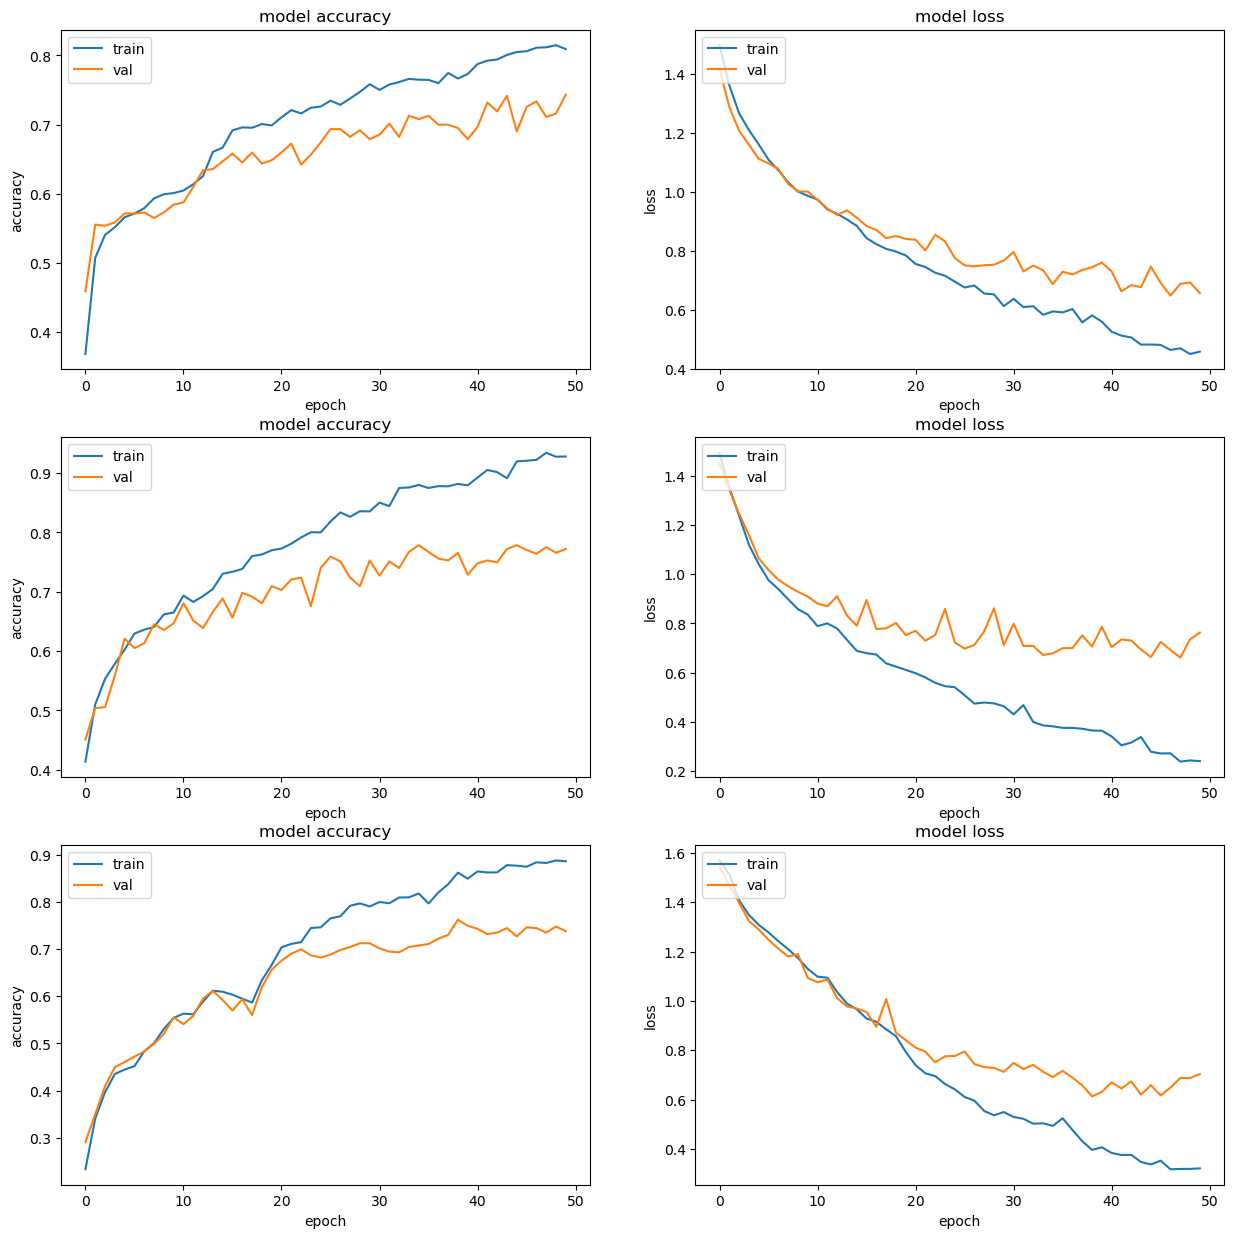

In [65]:
plot_stats(l1)

In [66]:
l2 = train_kfold(get_m, data2['xs'], data2['y'], metadata)

Epoch 1/50
111/111 [==============================] - 3s 17ms/step - loss: 1.4387 - accuracy: 0.3881 - val_loss: 1.2930 - val_accuracy: 0.5040
Epoch 2/50
111/111 [==============================] - 2s 14ms/step - loss: 1.2385 - accuracy: 0.5096 - val_loss: 1.2487 - val_accuracy: 0.5281
Epoch 3/50
111/111 [==============================] - 1s 13ms/step - loss: 1.1776 - accuracy: 0.5897 - val_loss: 1.1284 - val_accuracy: 0.6067
Epoch 4/50
111/111 [==============================] - 2s 14ms/step - loss: 1.1283 - accuracy: 0.5890 - val_loss: 1.1335 - val_accuracy: 0.5907
Epoch 5/50
111/111 [==============================] - 1s 13ms/step - loss: 1.0635 - accuracy: 0.6243 - val_loss: 1.0158 - val_accuracy: 0.6404
Epoch 6/50
111/111 [==============================] - 1s 13ms/step - loss: 1.0120 - accuracy: 0.6322 - val_loss: 0.9377 - val_accuracy: 0.6693
Epoch 7/50
111/111 [==============================] - 1s 13ms/step - loss: 0.9820 - accuracy: 0.6418 - val_loss: 0.9634 - val_accuracy: 0.6437

Epoch 8/50
111/111 [==============================] - 2s 15ms/step - loss: 1.2187 - accuracy: 0.5360 - val_loss: 1.2283 - val_accuracy: 0.5425
Epoch 9/50
111/111 [==============================] - 2s 15ms/step - loss: 1.1846 - accuracy: 0.5597 - val_loss: 1.2062 - val_accuracy: 0.5457
Epoch 10/50
111/111 [==============================] - 2s 15ms/step - loss: 1.1682 - accuracy: 0.5550 - val_loss: 1.1688 - val_accuracy: 0.5698
Epoch 11/50
111/111 [==============================] - 2s 15ms/step - loss: 1.1331 - accuracy: 0.5864 - val_loss: 1.1230 - val_accuracy: 0.5730
Epoch 12/50
111/111 [==============================] - 2s 15ms/step - loss: 1.0743 - accuracy: 0.5895 - val_loss: 1.0746 - val_accuracy: 0.5907
Epoch 13/50
111/111 [==============================] - 2s 15ms/step - loss: 1.0354 - accuracy: 0.6024 - val_loss: 1.0423 - val_accuracy: 0.6003
Epoch 14/50
111/111 [==============================] - 2s 15ms/step - loss: 1.0150 - accuracy: 0.6037 - val_loss: 1.0337 - val_accuracy: 0

Epoch 15/50
111/111 [==============================] - 2s 15ms/step - loss: 0.6726 - accuracy: 0.7565 - val_loss: 0.6798 - val_accuracy: 0.7480
Epoch 16/50
111/111 [==============================] - 2s 15ms/step - loss: 0.6339 - accuracy: 0.7621 - val_loss: 0.6639 - val_accuracy: 0.7448
Epoch 17/50
111/111 [==============================] - 2s 15ms/step - loss: 0.6432 - accuracy: 0.7724 - val_loss: 0.6505 - val_accuracy: 0.7624
Epoch 18/50
111/111 [==============================] - 2s 15ms/step - loss: 0.6101 - accuracy: 0.7849 - val_loss: 0.5959 - val_accuracy: 0.7897
Epoch 19/50
111/111 [==============================] - 2s 15ms/step - loss: 0.5700 - accuracy: 0.8018 - val_loss: 0.6359 - val_accuracy: 0.7608
Epoch 20/50
111/111 [==============================] - 2s 15ms/step - loss: 0.5474 - accuracy: 0.8102 - val_loss: 0.6287 - val_accuracy: 0.7512
Epoch 21/50
111/111 [==============================] - 2s 15ms/step - loss: 0.5534 - accuracy: 0.8083 - val_loss: 0.6030 - val_accuracy:

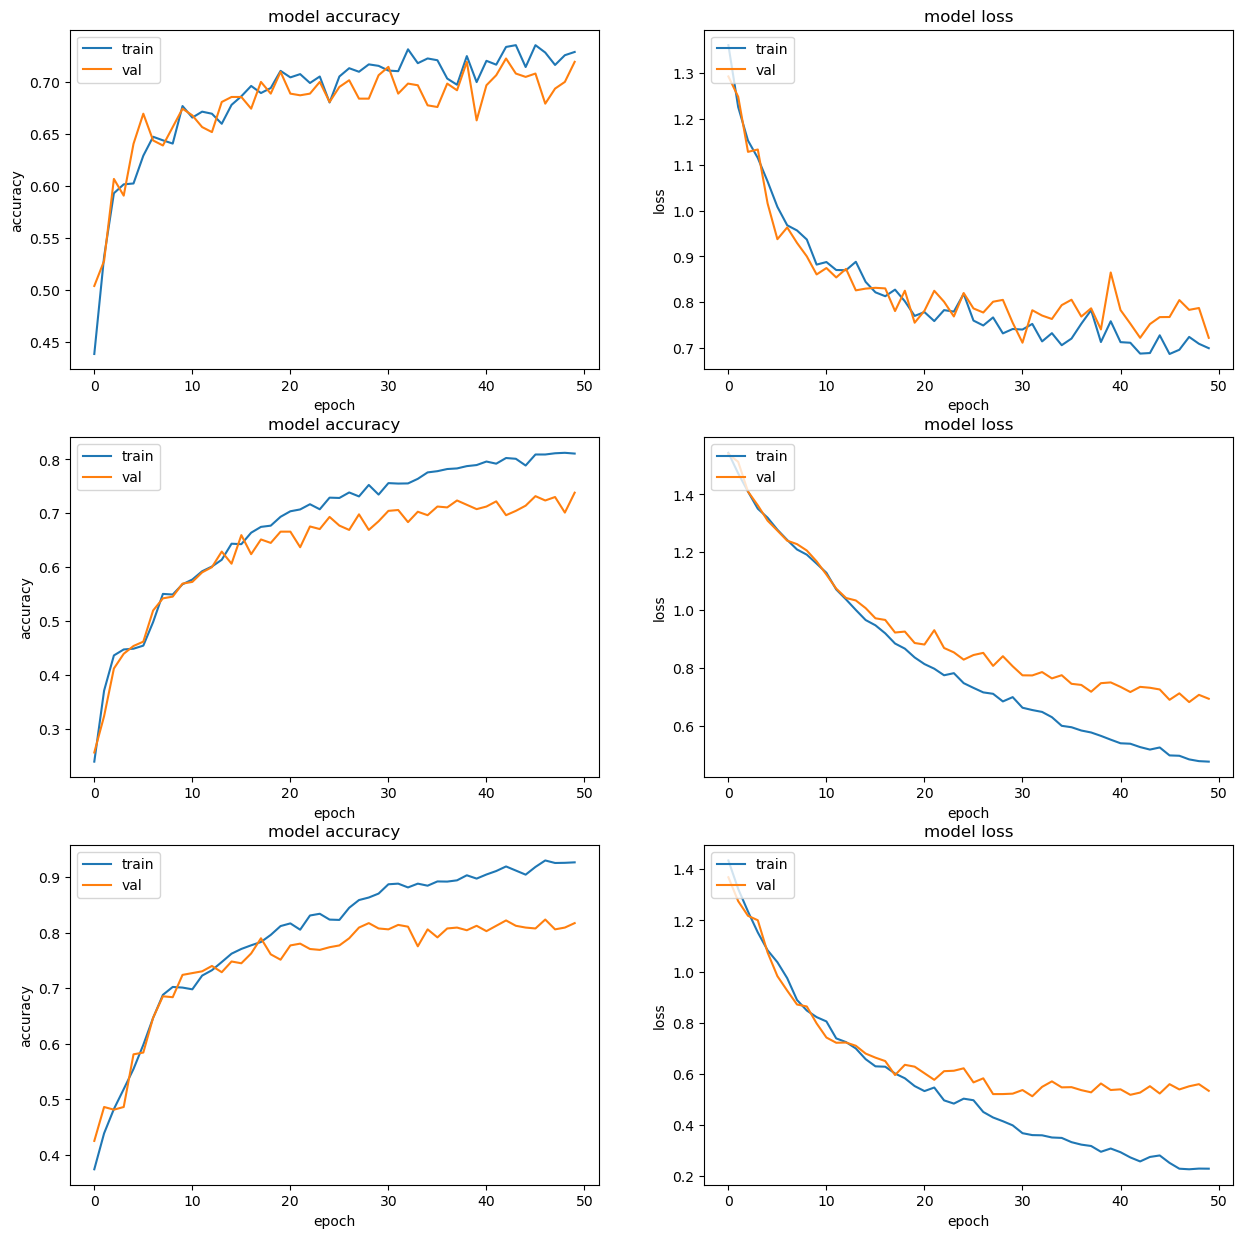

In [67]:
plot_stats(l2)

In [68]:
l3 = train_kfold(get_m, data3['xs'], data3['y'], metadata)

Epoch 1/50
111/111 [==============================] - 3s 18ms/step - loss: 1.4934 - accuracy: 0.3378 - val_loss: 1.3882 - val_accuracy: 0.4334
Epoch 2/50
111/111 [==============================] - 2s 15ms/step - loss: 1.4133 - accuracy: 0.4148 - val_loss: 1.3291 - val_accuracy: 0.4430
Epoch 3/50
111/111 [==============================] - 2s 15ms/step - loss: 1.3074 - accuracy: 0.4430 - val_loss: 1.2346 - val_accuracy: 0.4639
Epoch 4/50
111/111 [==============================] - 2s 15ms/step - loss: 1.2067 - accuracy: 0.4997 - val_loss: 1.1725 - val_accuracy: 0.5377
Epoch 5/50
111/111 [==============================] - 2s 14ms/step - loss: 1.1456 - accuracy: 0.5325 - val_loss: 1.1343 - val_accuracy: 0.5281
Epoch 6/50
111/111 [==============================] - 2s 14ms/step - loss: 1.1240 - accuracy: 0.5331 - val_loss: 1.1322 - val_accuracy: 0.5281
Epoch 7/50
111/111 [==============================] - 2s 15ms/step - loss: 1.0908 - accuracy: 0.5428 - val_loss: 1.0674 - val_accuracy: 0.5554

Epoch 8/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8462 - accuracy: 0.6780 - val_loss: 0.8842 - val_accuracy: 0.6726
Epoch 9/50
111/111 [==============================] - 2s 15ms/step - loss: 0.7739 - accuracy: 0.7193 - val_loss: 0.8273 - val_accuracy: 0.6854
Epoch 10/50
111/111 [==============================] - 2s 15ms/step - loss: 0.7607 - accuracy: 0.7351 - val_loss: 0.7835 - val_accuracy: 0.7014
Epoch 11/50
111/111 [==============================] - 2s 15ms/step - loss: 0.7105 - accuracy: 0.7382 - val_loss: 0.8144 - val_accuracy: 0.6726
Epoch 12/50
111/111 [==============================] - 2s 15ms/step - loss: 0.6754 - accuracy: 0.7593 - val_loss: 0.7933 - val_accuracy: 0.6982
Epoch 13/50
111/111 [==============================] - 2s 14ms/step - loss: 0.6584 - accuracy: 0.7579 - val_loss: 0.7585 - val_accuracy: 0.7175
Epoch 14/50
111/111 [==============================] - 2s 15ms/step - loss: 0.6105 - accuracy: 0.7887 - val_loss: 0.7343 - val_accuracy: 0

Epoch 15/50
111/111 [==============================] - 2s 15ms/step - loss: 1.0016 - accuracy: 0.6021 - val_loss: 0.9947 - val_accuracy: 0.6019
Epoch 16/50
111/111 [==============================] - 2s 15ms/step - loss: 0.9570 - accuracy: 0.6248 - val_loss: 0.9724 - val_accuracy: 0.6212
Epoch 17/50
111/111 [==============================] - 2s 14ms/step - loss: 0.9481 - accuracy: 0.6689 - val_loss: 0.9363 - val_accuracy: 0.6501
Epoch 18/50
111/111 [==============================] - 2s 15ms/step - loss: 0.9026 - accuracy: 0.6736 - val_loss: 0.9504 - val_accuracy: 0.6308
Epoch 19/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8699 - accuracy: 0.6952 - val_loss: 0.9071 - val_accuracy: 0.6613
Epoch 20/50
111/111 [==============================] - 2s 15ms/step - loss: 0.8511 - accuracy: 0.7001 - val_loss: 0.8552 - val_accuracy: 0.6854
Epoch 21/50
111/111 [==============================] - 1s 13ms/step - loss: 0.8224 - accuracy: 0.7160 - val_loss: 0.8640 - val_accuracy:

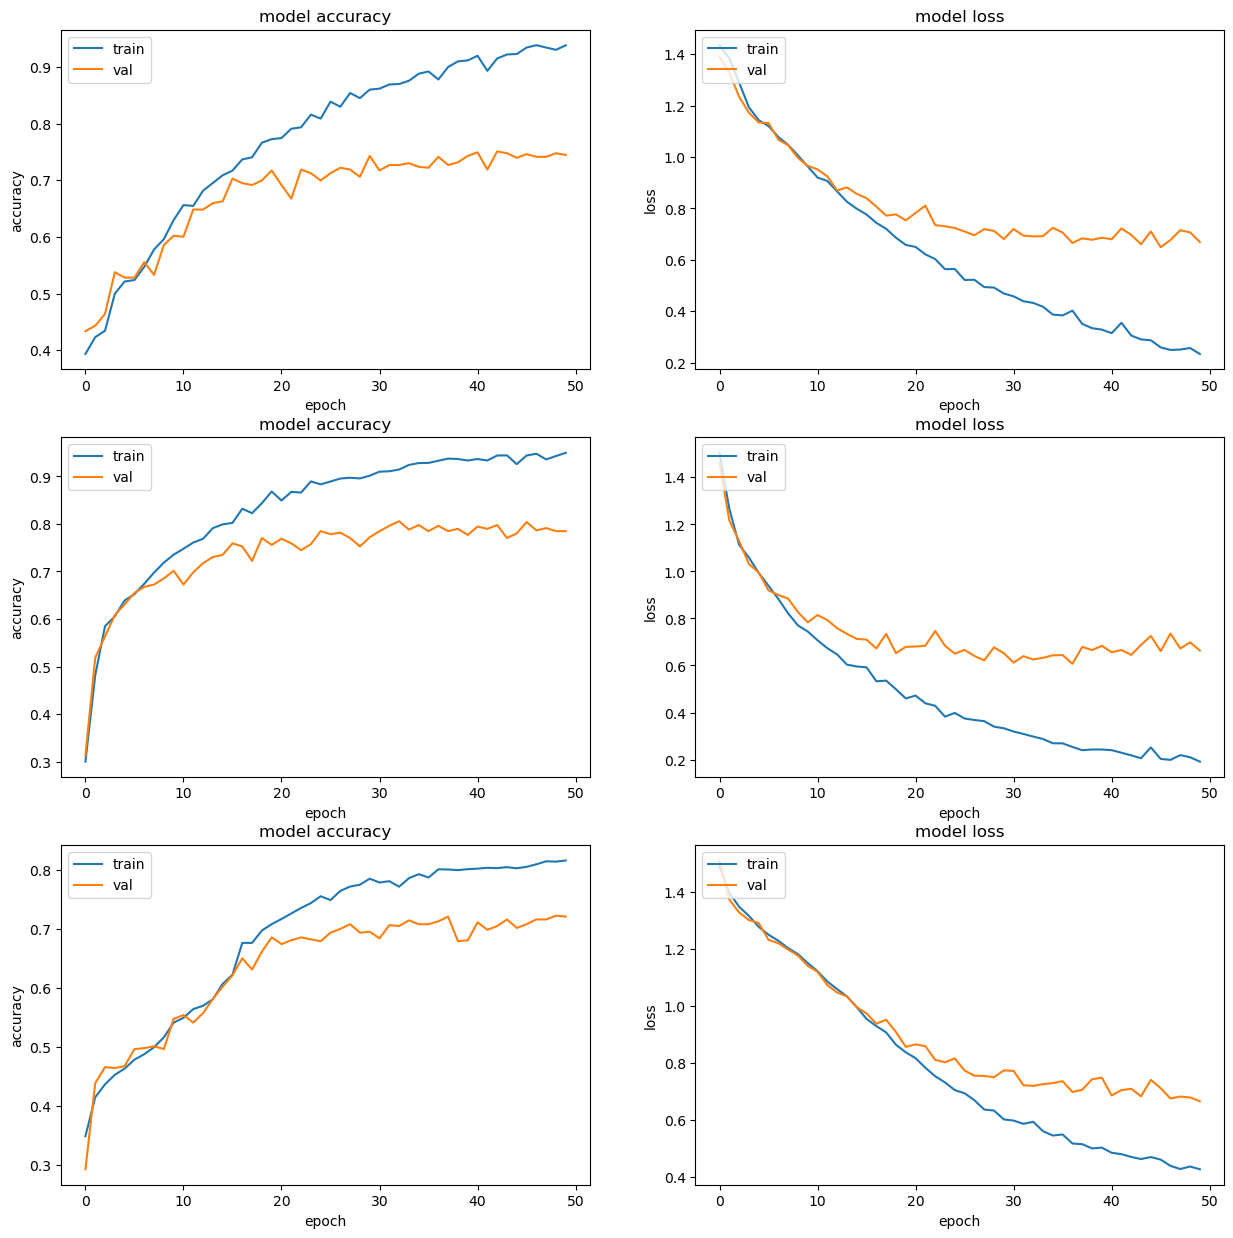

In [69]:
plot_stats(l3)